In [99]:
import pandas as pd
import requests
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
url = 'https://en.wikipedia.org/wiki/History_of_Federal_Open_Market_Committee_actions'
html = requests.get(url).content
df_list = pd.read_html(html)
massivechanges = df_list[1]

In [7]:
priceoffutures = pd.read_csv('30-day-fed-funds-futures.csv')

In [18]:
date_time_str = 'January 29, 2003'
date_time_obj = datetime.strptime(date_time_str, '%B %d, %Y')

In [20]:
date_time_obj

datetime.datetime(2003, 1, 29, 0, 0)

In [22]:
massivechanges['Converted_Datetime'] = massivechanges['Date'].apply(lambda x:datetime.strptime(x, '%B %d, %Y'))

In [ ]:
del massivechanges['Votes']
del massivechanges['Date']
del massivechanges['Notes']
del massivechanges['Discount Rate']

In [30]:
massivechanges

,Fed. Funds Rate,Converted_Datetime
0,0%–0.25%,2020-03-15
1,1%–1.25%,2020-03-03
2,1.50%–1.75%,2019-10-30
3,1.75%–2.00%,2019-09-18
4,2.00%–2.25%,2019-07-31
...,...,...
61,1.25%,2003-05-06
62,1.25%,2003-03-18
63,1.25%,2003-01-29
64,1.25%,2003-01-09


In [33]:
priceoffutures['Date'] = priceoffutures['date'].apply(lambda x:datetime.strptime(x, '%m/%d/%Y'))

In [35]:
del priceoffutures['date']

In [47]:
def parsestring(s):
    if chr(8211) in s:
        wow = s.split(chr(8211))
        s1 = wow[0][:-1]
        s2 = wow[1][:-1]
        return (float(s1) + float(s2)) / 2
    else:
        return float(s[:-1])

In [46]:
massivechanges['Rate'] = massivechanges['Fed. Funds Rate'].apply(parsestring)

['0%', '0.25%']
['1%', '1.25%']
['1.50%', '1.75%']
['1.75%', '2.00%']
['2.00%', '2.25%']
['2.25%', '2.50%']
['2.00%', '2.25%']
['1.75%', '2.00%']
['1.50%', '1.75%']
['1.25%', '1.50%']
['1.00%', '1.25%']
['0.75%', '1.00%']
['0.50%', '0.75%']
['0.25%', '0.50%']
['0.00%', '0.25%']
['0.00%', '0.25%']


In [49]:
del massivechanges['Fed. Funds Rate']

In [50]:
massivechanges

,Converted_Datetime,Rate
0,2020-03-15,0.125
1,2020-03-03,1.125
2,2019-10-30,1.625
3,2019-09-18,1.875
4,2019-07-31,2.125
...,...,...
61,2003-05-06,1.250
62,2003-03-18,1.250
63,2003-01-29,1.250
64,2003-01-09,1.250


In [58]:
priceoffutures_dict = {}
for i in range(priceoffutures.shape[0]):
    priceoffutures_dict[priceoffutures['Date'][i]] = priceoffutures[' value'][i]

In [62]:
massivechanges['DayofWeek'] = massivechanges['Converted_Datetime'].apply(lambda x : datetime.weekday(x))

In [98]:
priceoffutures


,value,Date
0,91.710,1988-10-03
1,91.710,1988-10-04
2,91.730,1988-10-05
3,91.700,1988-10-06
4,91.780,1988-10-07
...,...,...
8004,99.920,2020-07-23
8005,99.920,2020-07-24
8006,99.925,2020-07-27
8007,99.922,2020-07-28


In [67]:
def rowinpriceoffutures(i):
    for j in range(len(priceoffutures['Date'])):
        if priceoffutures['Date'][j] > i:
            return j-1
    return -1

In [68]:
massivechanges['rowinpriceoffutures'] = massivechanges['Converted_Datetime'].apply(lambda x : rowinpriceoffutures(x))

In [76]:
returnlist = []
for i in range(len(massivechanges['rowinpriceoffutures'])):
    if massivechanges['DayofWeek'][i] == 5 or massivechanges['DayofWeek'][i] == 6:
        returnlist.append(priceoffutures['Date'][massivechanges['rowinpriceoffutures'][i]])
    else:
        returnlist.append(priceoffutures['Date'][massivechanges['rowinpriceoffutures'][i]-1])

massivechanges['Day before'] = pd.Series(returnlist)


In [78]:
returnlist = []
for i in range(len(massivechanges['rowinpriceoffutures'])):
        returnlist.append(priceoffutures['Date'][massivechanges['rowinpriceoffutures'][i]+1])

massivechanges['Day after'] = pd.Series(returnlist)

In [89]:
massivechanges['Ratedaybefore'] = massivechanges['Day before'].apply(lambda x : priceoffutures_dict[x])

In [94]:
massivechanges['Ratedayafter'] = massivechanges['Day after'].apply(lambda x : priceoffutures_dict[x])

In [95]:
massivechanges['difference'] = massivechanges['Ratedaybefore'] - massivechanges['Ratedayafter']

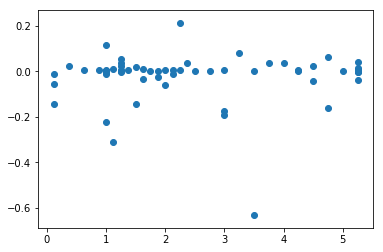

In [100]:
plt.scatter(massivechanges['Rate'], massivechanges['difference'])
plt.show()

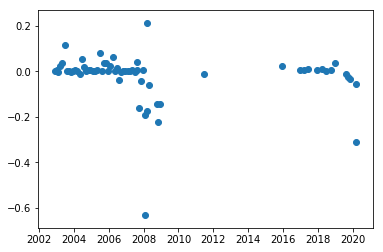

In [101]:
plt.scatter(massivechanges['Converted_Datetime'], massivechanges['difference'])
plt.show()

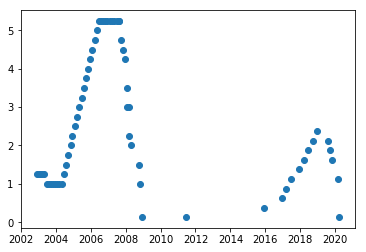

In [103]:
plt.scatter(massivechanges['Converted_Datetime'], massivechanges['Rate'])
plt.show()

In [104]:
returnlist = []
for i in range(len(massivechanges['Rate'])):
    if i == 0:
        returnlist.append(0)
    else:
        returnlist.append(massivechanges['Rate'][i] - massivechanges['Rate'][i-1])
massivechanges['Rate Changes'] = pd.Series(returnlist)

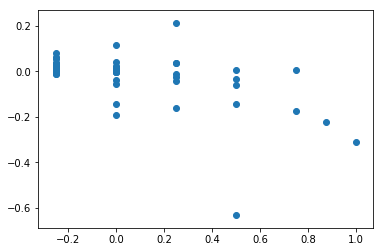

In [108]:
plt.scatter(massivechanges['Rate Changes'], massivechanges['difference'])
plt.show()

In [106]:
massivechanges

,Converted_Datetime,Rate,DayofWeek,rowinpriceoffutures,Day before,Day after,Ratedaybefore,Ratedayafter,difference,Rate Changes
0,2020-03-15,0.125,6,7913,2020-03-13,2020-03-16,99.840,99.8950,-0.0550,0.00
1,2020-03-03,1.125,1,7905,2020-03-02,2020-03-04,98.910,99.2200,-0.3100,1.00
2,2019-10-30,1.625,2,7821,2019-10-29,2019-10-31,98.407,98.4425,-0.0355,0.50
3,2019-09-18,1.875,2,7791,2019-09-17,2019-09-19,98.095,98.1200,-0.0250,0.25
4,2019-07-31,2.125,2,7757,2019-07-30,2019-08-01,97.930,97.9400,-0.0100,0.25
...,...,...,...,...,...,...,...,...,...,...
61,2003-05-06,1.250,1,3671,2003-05-05,2003-05-07,98.825,98.7900,0.0350,0.25
62,2003-03-18,1.250,1,3637,2003-03-17,2003-03-19,98.830,98.8050,0.0250,0.00
63,2003-01-29,1.250,2,3604,2003-01-28,2003-01-30,98.780,98.7820,-0.0020,0.00
64,2003-01-09,1.250,3,3591,2003-01-08,2003-01-10,98.775,98.7700,0.0050,0.00
